# Effect of Vaccines on Covid-19 fatality rate in Colombia

#### Objective:
Understand the effects that mass vaccination is having on the fatality rate of the Covid-19 virus in Colombia.
The population is segmented by age groups and a comparison is made of the fatality rate of the virus in each one of them at the start of vaccination versus at the present time..

#### Tools
- Pandas, seaborn, matplotlib, ipython-sql (SQL Magic extention)

---
#### Importing packges and SQL Server database connection

In [1]:
#importing packeges
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#database connection: #mssql://Host_name/Database_name?driver=Driver_name
%load_ext sql
%sql mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server

In [13]:
#checking connection
conn = %sql l / --connections
print(conn)

{'mssql://CAMILO-PCI5\\SQLEXPRESS/CovidColombia?driver=SQL+Server': <sql.connection.Connection object at 0x0000021F603DFE80>}


---
#### Testing connection by retreving columns info

In [4]:
%%sql
SELECT COLUMN_NAME, DATA_TYPE from INFORMATION_SCHEMA.COLUMNS
WHERE 
 TABLE_NAME = 'Casos'

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


COLUMN_NAME,DATA_TYPE
fecha_reporte_web,date
id_caso,int
fecha_notificacion,date
codigo_divipola_dpto,int
nombre_dpto,varchar
codigo_divipola_municipio,int
nombre_municipio,varchar
edad,int
unidad_medida_edad,int
sexo,varchar


---
#### Retrieving the cleaned dataset

In [5]:
%%sql
SELECT TOP 5 fecha_reporte_web, id_caso, edad, unidad_medida_edad, sexo, estado, fecha_muerte
FROM Casos
ORDER BY fecha_reporte_web

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


fecha_reporte_web,id_caso,edad,unidad_medida_edad,sexo,estado,fecha_muerte
2020-03-06,1,19,1,F,Recuperado,None
2020-03-09,2,34,1,M,Recuperado,None
2020-03-09,3,50,1,F,Recuperado,None
2020-03-11,4,55,1,M,Recuperado,None
2020-03-11,5,25,1,M,Recuperado,None


---
#### **Total Cases** reported to date

In [34]:
r0 = %sql SELECT COUNT(*) FROM Casos
total_cases = r0[0][0]

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


In [35]:
total_pop = 50339000
prop_pop_inf = round((total_cases/total_pop)*100,2)
print('Total cases reported to date =',total_cases)
print('Proportion of the population infected =',prop_pop_inf, '%')

Total cases reported to date = 4565372
Proportion of the population infected = 9.07 %


---
#### **Total Deaths and Fatality Rate** reported to date

In [39]:
r1 = %sql SELECT estado, COUNT(estado) AS cantidad FROM Casos GROUP BY estado ORDER BY cantidad

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


In [40]:
df_r1 = r1.DataFrame()
df_r1['porcentaje'] = round((df_r1['cantidad']/total_cases)*100,2)
df_r1

,estado,cantidad,porcentaje
0,N/A,12926,0.28
1,Fallecido,114337,2.50
2,Activo,120673,2.64
3,Recuperado,4317436,94.57


([<matplotlib.patches.Wedge at 0x1e735e6e9d0>,
 [Text(1.099956485349573, 0.009784188132643572, 'N/A'),
  Text(1.0948855238937767, 0.10595135472399823, 'Fallecido'),
  Text(1.063539755390138, 0.28086151161148004, 'Activo'),
  Text(-1.0840288650002177, -0.18676568166111288, 'Recuperado')])

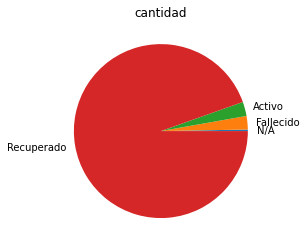

In [33]:
#ploting proportion of cases by status 
plot1 = r1.pie()
plot1

In [37]:
#mortality rate: proportion of deaths per unit of population (100,000 generally used)
#fatality rate: proportion of deaths compared to the total number of people diagnosed.

r2 = %sql SELECT COUNT(estado) FROM Casos WHERE estado = 'Fallecido'

total_deaths = r2[0][0]
gen_mortality = (total_deaths*100000/total_pop)
gen_fatality = (total_deaths/total_cases)*100

print('Total deaths =', total_deaths)
print('General Mortality rate =', round(gen_mortality,2), 'per 100,000 inhabitants')
print('General Fatality rate =', round(gen_fatality,3), '%')

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.
Total deaths = 114337
General Mortality rate = 227.13 per 100,000 inhabitants
General Fatality rate = 2.504 %


---
#### Total Cases and Deaths by **Gender**

In [12]:
%sql SELECT sexo, COUNT(*) AS 'no. de casos' FROM Casos GROUP BY sexo

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


sexo,no. de casos
F,2391249
M,2174123


In [11]:
%sql SELECT sexo, COUNT(*) AS 'no. de fallecidos' FROM Casos GROUP BY sexo, estado HAVING estado = 'Fallecido'

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


sexo,no. de fallecidos
F,44211
M,70126


- *Calculating **Fatality Rate** of each geneder:*

In [47]:
#Creating a dataframe from previous results and calculating fatality rate ("letalidad") of each gender:
df_r2 = pd.DataFrame({
    'sexo':['F','M'],
    'casos':[2391249, 2174123],
    'fallecidos':[44211,70126]
})
df_r2['%_fallecidos'] = round((df_r2['fallecidos']/total_deaths)*100,2)
df_r2['letalidad'] = round((df_r2['fallecidos']/df_r2['casos'])*100,2)
df_r2

,sexo,casos,fallecidos,%_fallecidos,letalidad
0,F,2391249,44211,38.67,1.85
1,M,2174123,70126,61.33,3.23


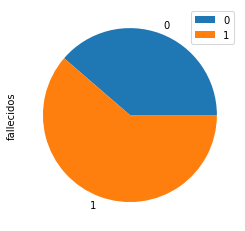

In [50]:
#ploting proportion of deaths by gender
plot2 = df_r2.plot.pie(y='fallecidos', figsize=(4,4))

---
#### Categorization of Cases by **Age Group**
We need to categorize the cases by age group in order to calculate the fatality rate of each group. For this we created a view called `Casos_con_grupo_etario` from the main dataset `Casos`. It should be noted that the column `unidad_medida_edad` indicates whether the age of each patient is measured in years, months or days.

In [ ]:
%%sql
--CREATE VIEW Casos_con_grupo_etario AS
SELECT fecha_reporte_web, id_caso, edad, unidad_medida_edad, sexo, estado, fecha_muerte,
CASE
 WHEN unidad_medida_edad = 1 THEN
   CASE
     WHEN edad <= 4 THEN '0 - 04'
     WHEN edad <= 9 THEN '05 - 09'
     WHEN edad <= 19 THEN '10 - 19'
     WHEN edad <= 29 THEN '20 - 29'
     WHEN edad <= 39 THEN '30 - 39'
     WHEN edad <= 49 THEN '40 - 49'
     WHEN edad <= 59 THEN '50 - 59'
     WHEN edad <= 69 THEN '60 - 69'
     WHEN edad <= 79 THEN '70 - 79'
     ELSE '80 o más'
   END
 ELSE '0 - 04'
END AS grupo_etario
FROM Casos;

In [11]:
#Checking the VIEW: Casos_con_grupo_etario
%sql SELECT TOP 5 * FROM Casos_con_grupo_etario ORDER BY fecha_reporte_web

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


fecha_reporte_web,id_caso,edad,unidad_medida_edad,sexo,estado,fecha_muerte,grupo_etario
2020-03-06,1,19,1,F,Recuperado,None,10 - 19
2020-03-09,2,34,1,M,Recuperado,None,30 - 39
2020-03-09,3,50,1,F,Recuperado,None,50 - 59
2020-03-11,4,55,1,M,Recuperado,None,50 - 59
2020-03-11,5,25,1,M,Recuperado,None,20 - 29


---
#### Grouping Cases and Deaths by **Age group** and **Gender**
First we group cases and deaths by Age Group and Gender in different queries. Then we **JOIN** the results of both **CTEs** tables into a single one and then create a new view from it, getting the number of **Cases and Deaths** by **Age Group** and **Gender** in the same table:

In [ ]:
%%sql
--CREATE VIEW agrupacion_por_grupoetario_y_sexo AS
WITH CTE1_muertes (grupo_etario, sexo, fallecidos) AS (
        SELECT grupo_etario, sexo, COUNT(grupo_etario) AS fallecidos
        FROM Casos_con_grupo_etario
        GROUP BY grupo_etario, sexo, estado
        HAVING estado = 'Fallecido'
        ),
    CTE2_casos (grupo_etario, sexo, casos) AS (
        SELECT grupo_etario, sexo, COUNT(grupo_etario) AS casos
        FROM Casos_con_grupo_etario
        GROUP BY grupo_etario, sexo
        )
SELECT m.grupo_etario, m.sexo, fallecidos, casos
FROM CTE1_muertes m
JOIN CTE2_casos c ON m.grupo_etario = c.grupo_etario AND m.sexo = c.sexo
ORDER BY m.grupo_etario

In [25]:
#Checking VIEW: agrupacion_por_grupoetario_y_sexo
%sql SELECT TOP 6 * FROM agrupacion_por_grupoetario_y_sexo ORDER BY grupo_etario

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


grupo_etario,sexo,fallecidos,casos
0 - 04,M,53,36191
0 - 04,F,43,33363
05 - 09,M,18,42022
05 - 09,F,11,41018
10 - 19,F,64,172715
10 - 19,M,78,162308


- *Calculating **Fatality Rate** by Age Group and Gender:*

In [16]:
%%sql
SELECT *, ROUND((CONVERT(FLOAT, fallecidos)/CONVERT(FLOAT, casos))*100,2) AS letalidad
FROM agrupacion_por_grupoetario_y_sexo
ORDER BY grupo_etario;

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


grupo_etario,sexo,fallecidos,casos,letalidad
0 - 04,M,53,36191,0.15
0 - 04,F,43,33363,0.13
05 - 09,M,18,42022,0.04
05 - 09,F,11,41018,0.03
10 - 19,F,64,172715,0.04
10 - 19,M,78,162308,0.05
20 - 29,F,533,517230,0.1
20 - 29,M,743,451502,0.16
30 - 39,F,1216,527228,0.23
30 - 39,M,2525,497208,0.51


- *What is the segment of the population (age group and gender) with the **highest fatality rate**?*

In [17]:
%%sql
WITH CTE1_letalidad (grupo_etario, sexo, fallecidos, casos, letalidad) AS (
    SELECT *, ROUND((CONVERT(FLOAT, fallecidos)/CONVERT(FLOAT, casos))*100,2) AS letalidad
    FROM agrupacion_por_grupoetario_y_sexo
    )
SELECT * 
FROM CTE1_letalidad
WHERE letalidad = (SELECT MAX(letalidad) FROM CTE1_letalidad)

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


grupo_etario,sexo,fallecidos,casos,letalidad
80 o más,M,15416,47056,32.76


---
#### Fatality Rate by **Age Group**
- *Calculating **Fatality Rate** just by Age Group:*

In [ ]:
%%sql
--CREATE VIEW letalidad_por_grupoetario AS
SELECT grupo_etario, SUM(fallecidos) AS fallecidos, SUM(casos) AS casos, ROUND((CONVERT(FLOAT, SUM(fallecidos))/CONVERT(FLOAT,SUM(casos)))*100,2) AS letalidad
FROM agrupacion_por_grupoetario_y_sexo
GROUP BY grupo_etario;

In [3]:
#Cheking view:
r3 = %sql SELECT * FROM letalidad_por_grupoetario ORDER BY grupo_etario
df_r3 = r3.DataFrame()
df_r3

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


,grupo_etario,fallecidos,casos,letalidad
0,0 - 04,96,69554,0.14
1,05 - 09,29,83040,0.03
2,10 - 19,142,335023,0.04
3,20 - 29,1276,968732,0.13
4,30 - 39,3741,1024436,0.37
5,40 - 49,8475,775370,1.09
6,50 - 59,17472,641485,2.72
7,60 - 69,27422,381152,7.19
8,70 - 79,28355,184232,15.39
9,80 o más,27329,102348,26.70


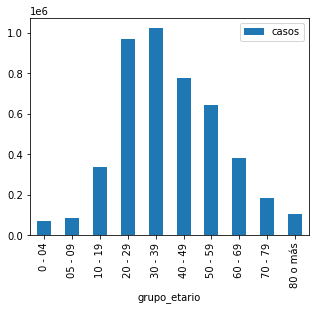

In [4]:
#cases by age group
plot3 = df_r3.plot.bar(x='grupo_etario', y='casos', figsize=(5,4))

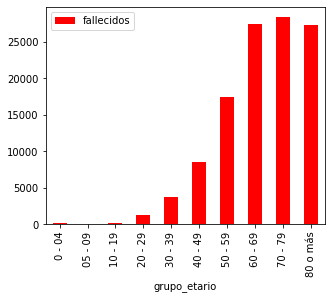

In [5]:
#deaths by age group
plot3_1 = df_r3.plot.bar(x='grupo_etario', y='fallecidos', figsize=(5,4), color = 'red')

- *What is the age group with the **highest fatality rate**?*

In [23]:
%sql SELECT * FROM letalidad_por_grupoetario WHERE letalidad = (SELECT MAX(letalidad) FROM letalidad_por_grupoetario)

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


grupo_etario,fallecidos,casos,letalidad
80 o más,27329,102348,26.7


- *What is the age group with the **lowest fatality rate**?*

In [22]:
%sql SELECT * FROM letalidad_por_grupoetario WHERE letalidad = (SELECT MIN(letalidad) FROM letalidad_por_grupoetario);

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


grupo_etario,fallecidos,casos,letalidad
05 - 09,29,83040,0.03


> **Remarks:**
>- *Within each age group, the gender with the highest latility rate is the Male, having a greater risk of death if they contract the disease.*
>- *The age groups with the highest latality rate are the more advance ones: `60 - 69`, `70 - 79` and `80 o más` with 7.2%, 15.4% and 26.7% respectively.*
>- *The fatality rate of these groups is quite high compared with the general rate that is 2.50%.*
>- *It is shown that we cannot use the general fatality rate as a comparable measure for all age groups.*

---
#### Effect of vaccines on Fatality Rate
Next, we will study how the fatality rate of each age group has evolved from month to month since the start of the pandemic. We will focus primarily on comparing the behavior of this measure before and after the start of vaccination in February 2021. We will see if there is any positive effect by reducing mortality for each age group.

- *Grouping Cases and Deaths by **Month** and **Age group**:*

In [ ]:
%%sql
--CREATE VIEW agrupacion_por_mes_y_grupoetario AS
WITH CTE3_casos (año, mes, grupo_etario, casos) AS (
      SELECT YEAR(fecha_reporte_web) AS año, MONTH(fecha_reporte_web) AS mes, grupo_etario, COUNT(fecha_reporte_web) AS casos
      FROM Casos_con_grupo_etario
      GROUP BY YEAR(fecha_reporte_web), MONTH(fecha_reporte_web), grupo_etario
      ),
    CTE4_muertes (año, mes, grupo_etario, fallecidos) AS (
      SELECT YEAR(fecha_muerte) AS año, MONTH(fecha_muerte) AS mes, grupo_etario, COUNT(fecha_muerte) AS fallecidos
      FROM Casos_con_grupo_etario
      GROUP BY YEAR(fecha_muerte), MONTH(fecha_muerte), grupo_etario, estado
      HAVING estado = 'Fallecido'
      )
SELECT c.año, c.mes, c.grupo_etario, fallecidos, casos
FROM CTE3_casos c
LEFT JOIN CTE4_muertes m ON c.año = m.año AND c.mes = m.mes AND c.grupo_etario = m.grupo_etario

In [31]:
#Checking view:
%sql SELECT TOP 5 * FROM agrupacion_por_mes_y_grupoetario ORDER BY año, mes, grupo_etario;

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


año,mes,grupo_etario,fallecidos,casos
2020,3,0 - 04,1,7
2020,3,05 - 09,None,7
2020,3,10 - 19,1,31
2020,3,20 - 29,2,195
2020,3,30 - 39,4,208


- *Calculating general Fatality Rate by **Month**:*

In [6]:
%%sql r4 <<
SELECT CONCAT(año,'-', mes) AS año_mes, SUM(fallecidos) AS fallecidos, SUM(casos) AS casos, ROUND((CONVERT(FLOAT, SUM(fallecidos))/CONVERT(FLOAT,SUM(casos)))*100,2) AS letalidad
FROM agrupacion_por_mes_y_grupoetario
GROUP BY año, mes
ORDER BY año, mes

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.
Returning data to local variable r4


In [15]:
df_r4 = r4.DataFrame()
df_r4

,año_mes,fallecidos,casos,letalidad
0,2020-3,32,905,3.54
1,2020-4,331,5560,5.95
2,2020-5,873,22917,3.81
3,2020-6,3119,68471,4.56
4,2020-7,7685,197663,3.89
5,2020-8,8971,319661,2.81
6,2020-9,5746,214510,2.68
7,2020-10,5344,244502,2.19
8,2020-11,5414,242662,2.23
9,2020-12,6793,325951,2.08


<function matplotlib.pyplot.show(close=None, block=None)>

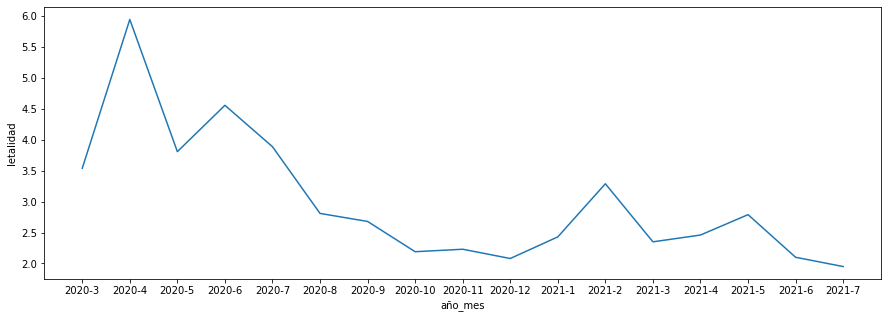

In [14]:
plt.figure(figsize=(15,5))
plot = sns.lineplot(x='año_mes', y='letalidad', data = df_r4)
plt.show

>**Remarks:**
> - *During the first months the general fatality rate remains is very high. It begins to stabilize at values between 2% and 3% from month 08-2020.*
> - *After 3 months of vaccination, from month 05-2021, a downward trend in fatality is observed reaching 1.95% in 07-2021. It is the lowest value in the entire pandemic.*

- *Calculating Fatality Rate by **Month** and **Age Group**:*

In [ ]:
%%sql
--CREATE VIEW letalidad_por_grupoetario_por_mes AS
SELECT año, mes, CONCAT(año,'-', mes) AS año_mes, grupo_etario, fallecidos, casos, ROUND((CONVERT(FLOAT, fallecidos)/CONVERT(FLOAT,casos))*100,2) AS letalidad
FROM agrupacion_por_mes_y_grupoetario
ORDER BY año, mes, grupo_etario

In [34]:
#Cheking view and convertint it to dataframe:
r5 = %sql SELECT * FROM letalidad_por_grupoetario_por_mes ORDER BY año, mes, grupo_etario
df_5 = r5.DataFrame()
df_5.iloc[:,2:]

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


,año_mes,grupo_etario,fallecidos,casos,letalidad
0,2020-3,0 - 04,1.0,7,14.29
1,2020-3,05 - 09,NaN,7,NaN
2,2020-3,10 - 19,1.0,31,3.23
3,2020-3,20 - 29,2.0,195,1.03
4,2020-3,30 - 39,4.0,208,1.92
...,...,...,...,...,...
165,2021-7,40 - 49,848.0,61161,1.39
166,2021-7,50 - 59,1181.0,37676,3.13
167,2021-7,60 - 69,1381.0,21600,6.39
168,2021-7,70 - 79,1247.0,10757,11.59


- *Ploting Fatality Rate by **Month** and **Age Group**:*

<function matplotlib.pyplot.show(close=None, block=None)>

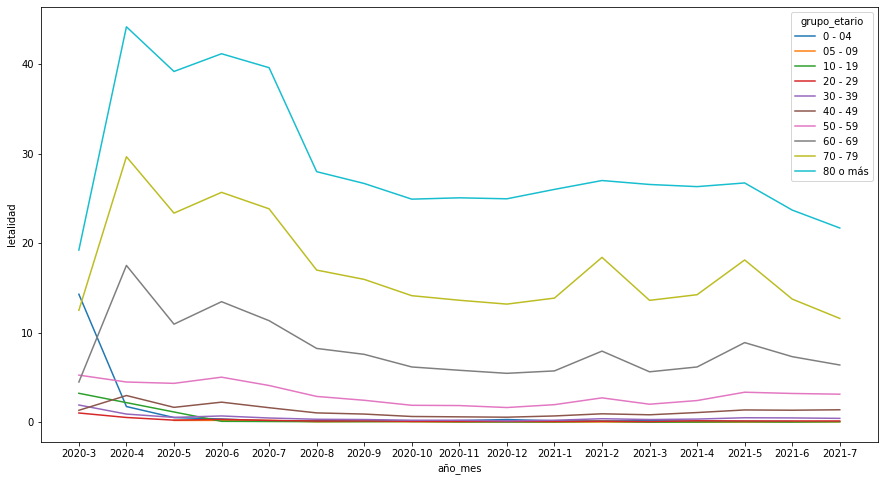

In [18]:
plt.figure(figsize=(15,8))
plot = sns.lineplot(x='año_mes', y='letalidad', hue='grupo_etario', data=df_5)
plt.show

- *Filtering **'80 o más'** age group:*

 * mssql://CAMILO-PCI5\SQLEXPRESS/CovidColombia?driver=SQL+Server
Done.


<function matplotlib.pyplot.show(close=None, block=None)>

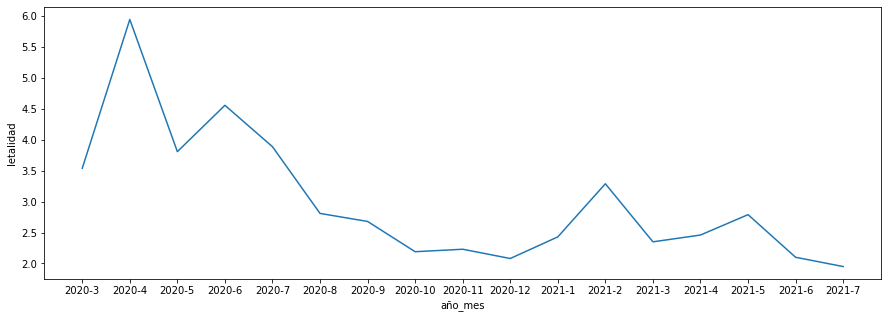

In [40]:
resultado3 = %sql SELECT * FROM letalidad_por_grupoetario_por_mes WHERE grupo_etario = '80 o más' ORDER BY año, mes, grupo_etario
df_letalidad_ge = resultado.DataFrame()
plt.figure(figsize=(15,5))
plot = sns.lineplot(x='año_mes', y='letalidad', data = df_letalidad_ge)
plt.show

>**Remarks:**
>- *The fatality rate tends to be higher in older age groups. This behavior is maintained month by month throughout the pandemic, confirming that older people have been the hardest hit by the virus. Therefore, it is correct to conclude that the older a person is, the greater risk of dying if they contract the disease.*
>- *According to the graphs, the people least affected by the pandemic are between 0 and 49 years old. In these age groups, fatality averages below 2%.*
>- *For the more advanced age groups, from 50 years old onwards, the changes in fatality rate are much more sensitive to the number of cases in each month.*
>- *During the first 3 months after the start of vaccination (02-2021), there does not seem to be a significant change that indicates a decrease in fatality rate, on the contrary, there are notable peaks and valleys in its behavior, given the sudden increase and decrease in the number of infections during those same months.*
>- *A decrease in the fatality rate is notorious only from 05-2021, which is the 4th month after the start of vaccination. Naturally, this change is noticeable in the more advanced age groups since they were a priority in the country's vaccination scheme.*
>- *The downward trend in the fatality rate is very pronounced in the "70 -79" and "80 or more" groups.*
>- *Fatality rate in the group of "80 or more" decreased from an average of 26.21% in the last 10 months to 21.69% in 07-2021. Fatality rate in the group of "70 - 79" decreased from an average of 15.51% in the last 10 months to 11.59% in 07-2021.*
>- *In other words, fatality rate has decreased by 17.24% for the group of "80 or more" and by 25.27% for the group of "70 - 79" after 6 months from the start of vaccination.*

---